In [4]:
import json
import pandas as pd
import os

In [2]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable


**Pass network data**

In [14]:
# Set correct file path — update this path if needed
json_path = os.path.join("..", "data", "1_Arg_vs_Saudi_G1", "1_Arg_vs_Saudi_G1.json")
print("🔎 Looking for JSON at:", os.path.abspath(json_path))
#json_path = r"data/1_Arg_vs_Saudi_G1/1_Arg_vs_Saudi_G1.json"
print(f"Loading JSON file from: {json_path}")
#abs_path = os.path.abspath(json_path)
# Load the JSON file
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Filter Real Madrid passes
pass_events = []
target_team = "Argentina"

for event in data:
    if event.get("type", {}).get("name") == "Pass" and event.get("team", {}).get("name") == target_team:
        passer = event.get("player", {}).get("name")
        recipient = event.get("pass", {}).get("recipient", {}).get("name")
        team = event.get("team", {}).get("name")
        outcome = event.get("pass", {}).get("outcome", {}).get("name", "Successful")
        success = outcome == "Successful"
        location = event.get("location", [None, None])
        end_location = event.get("pass", {}).get("end_location", [None, None])

        pass_events.append({
            "Passer": passer,
            "Recipient": recipient,
            "Team": team,
            "Pass Success": success,
            "Start X": location[0],
            "Start Y": location[1],
            "End X": end_location[0],
            "End Y": end_location[1]
        })

# Convert to DataFrame
passes_df = pd.DataFrame(pass_events)

# Create output folder in correct location (one level up from 'notebooks')
output_dir = os.path.join("..", "outputs", "argentina_saudi")
os.makedirs(output_dir, exist_ok=True)

# Save to Excel in the correct path
excel_path = os.path.join(output_dir, "arg_sau_passes.xlsx")
passes_df.to_excel(excel_path, index=False)

print(f"✅ Saved Argentina passes to: {os.path.abspath(excel_path)}")


🔎 Looking for JSON at: d:\Masters\hcnlp_project\data\1_Arg_vs_Saudi_G1\1_Arg_vs_Saudi_G1.json
Loading JSON file from: ..\data\1_Arg_vs_Saudi_G1\1_Arg_vs_Saudi_G1.json
✅ Saved Argentina passes to: d:\Masters\hcnlp_project\outputs\argentina_saudi\arg_sau_passes.xlsx


In [12]:
# Load the Excel file
df = pd.read_excel("D:/Masters/HCNLP/notebooks/output/real_madrid_passes.xlsx")

# Drop rows with missing passers or recipients
df = df.dropna(subset=["Passer", "Recipient"])

# Get unique players
players = sorted(set(df["Passer"]).union(set(df["Recipient"])))

# Initialize list to store rows
interaction_data = []

# Generate a dictionary of who passed to whom and how many times
pass_counts = df.groupby(["Passer", "Recipient"]).size().reset_index(name="Pass Count")

for player in players:
    row = {"Player": player}

    # Total passes made
    passes_made = df[df["Passer"] == player].shape[0]
    row["Total Passes Made"] = passes_made

    # Total passes received
    passes_received = df[df["Recipient"] == player].shape[0]
    row["Total Passes Received"] = passes_received

    # Pass counts to each teammate
    teammates = [p for p in players if p != player]
    for teammate in teammates:
        count = pass_counts[
            (pass_counts["Passer"] == player) &
            (pass_counts["Recipient"] == teammate)
        ]["Pass Count"].sum()
        row[teammate] = count

    interaction_data.append(row)

# Convert to DataFrame
interaction_df = pd.DataFrame(interaction_data)

# Save to Excel
interaction_df.to_excel("output/player_interactions.xlsx", index=False)
print("✅ Saved Player Interaction Sheet to 'output/player_interactions.xlsx'")


✅ Saved Player Interaction Sheet to 'output/player_interactions.xlsx'


C:\Users\harig\AppData\Local\Temp\ipykernel_19548\3081286487.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


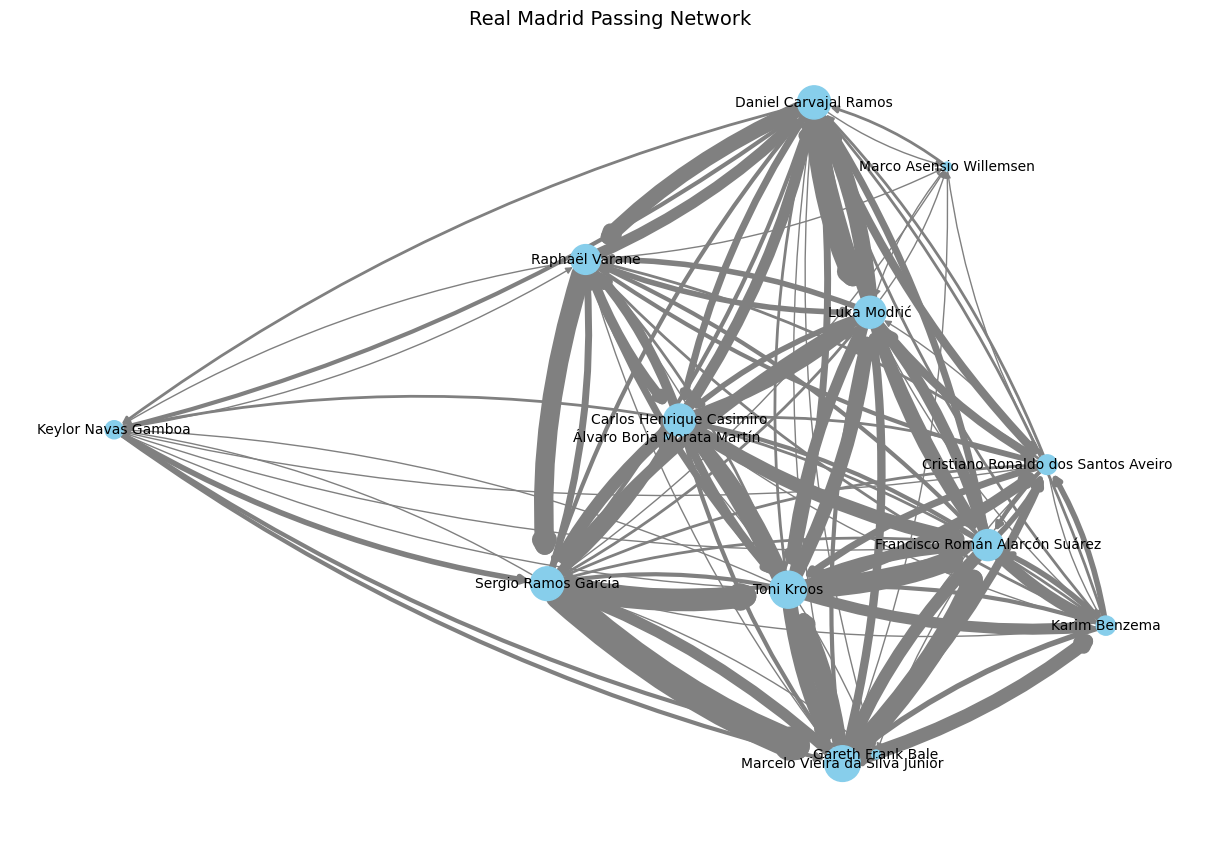

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# Load original pass data
df = pd.read_excel("D:/Masters/HCNLP/notebooks/output/real_madrid_passes.xlsx")

# Drop incomplete data
df = df.dropna(subset=["Passer", "Recipient", "Start X", "Start Y", "End X", "End Y"])

# Calculate average pass start location for each player (for node position)
positions = df.groupby("Passer")[["Start X", "Start Y"]].mean()

# Count how many passes each player made (for node size)
pass_counts = df["Passer"].value_counts()

# Get all unique players involved
all_players = set(df["Passer"]).union(set(df["Recipient"]))

# Create graph
G = nx.DiGraph()

# Add all nodes with default position and size if missing
for player in all_players:
    pos = tuple(positions.loc[player]) if player in positions.index else (50, 40)  # fallback to center
    size = pass_counts.get(player, 1)
    G.add_node(player, pos=pos, size=size)

# Add edges (weighted by pass frequency)
edge_data = df.groupby(["Passer", "Recipient"]).size().reset_index(name="weight")
for _, row in edge_data.iterrows():
    G.add_edge(row["Passer"], row["Recipient"], weight=row["weight"])

# Prepare drawing
plt.figure(figsize=(12, 8))
pos = nx.get_node_attributes(G, 'pos')
sizes = [G.nodes[n]['size'] * 10 for n in G.nodes]
weights = [G[u][v]['weight'] for u, v in G.edges]

# Draw network
nx.draw(G, pos, with_labels=True, arrows=True,
        node_size=sizes,
        width=weights,
        edge_color="gray",
        node_color="skyblue",
        font_size=10,
        connectionstyle='arc3,rad=0.1')

plt.title("Real Madrid Passing Network", fontsize=14)
plt.axis('off')
plt.tight_layout()
os.makedirs("output", exist_ok=True)
plt.savefig("output/real_madrid_pass_network.png", dpi=300)
plt.show()
